<a href="https://colab.research.google.com/github/Annmodels/lstm/blob/master/Multivariate_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 43kB/s 
     |████████████████████████████████| 3.9MB 38.7MB/s 
     |████████████████████████████████| 450kB 51.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=9199587906c32e78f01986a2242c0abc5aa5b0518166b09d43b66621319030e8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflo

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: /content/london_bike_sharing.csv
100% 1.03M/1.03M [00:00<00:00, 68.1MB/s]


In [0]:
df = pd.read_csv(
  "london_bike_sharing.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [0]:
df.shape

(17414, 9)

In [0]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [0]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

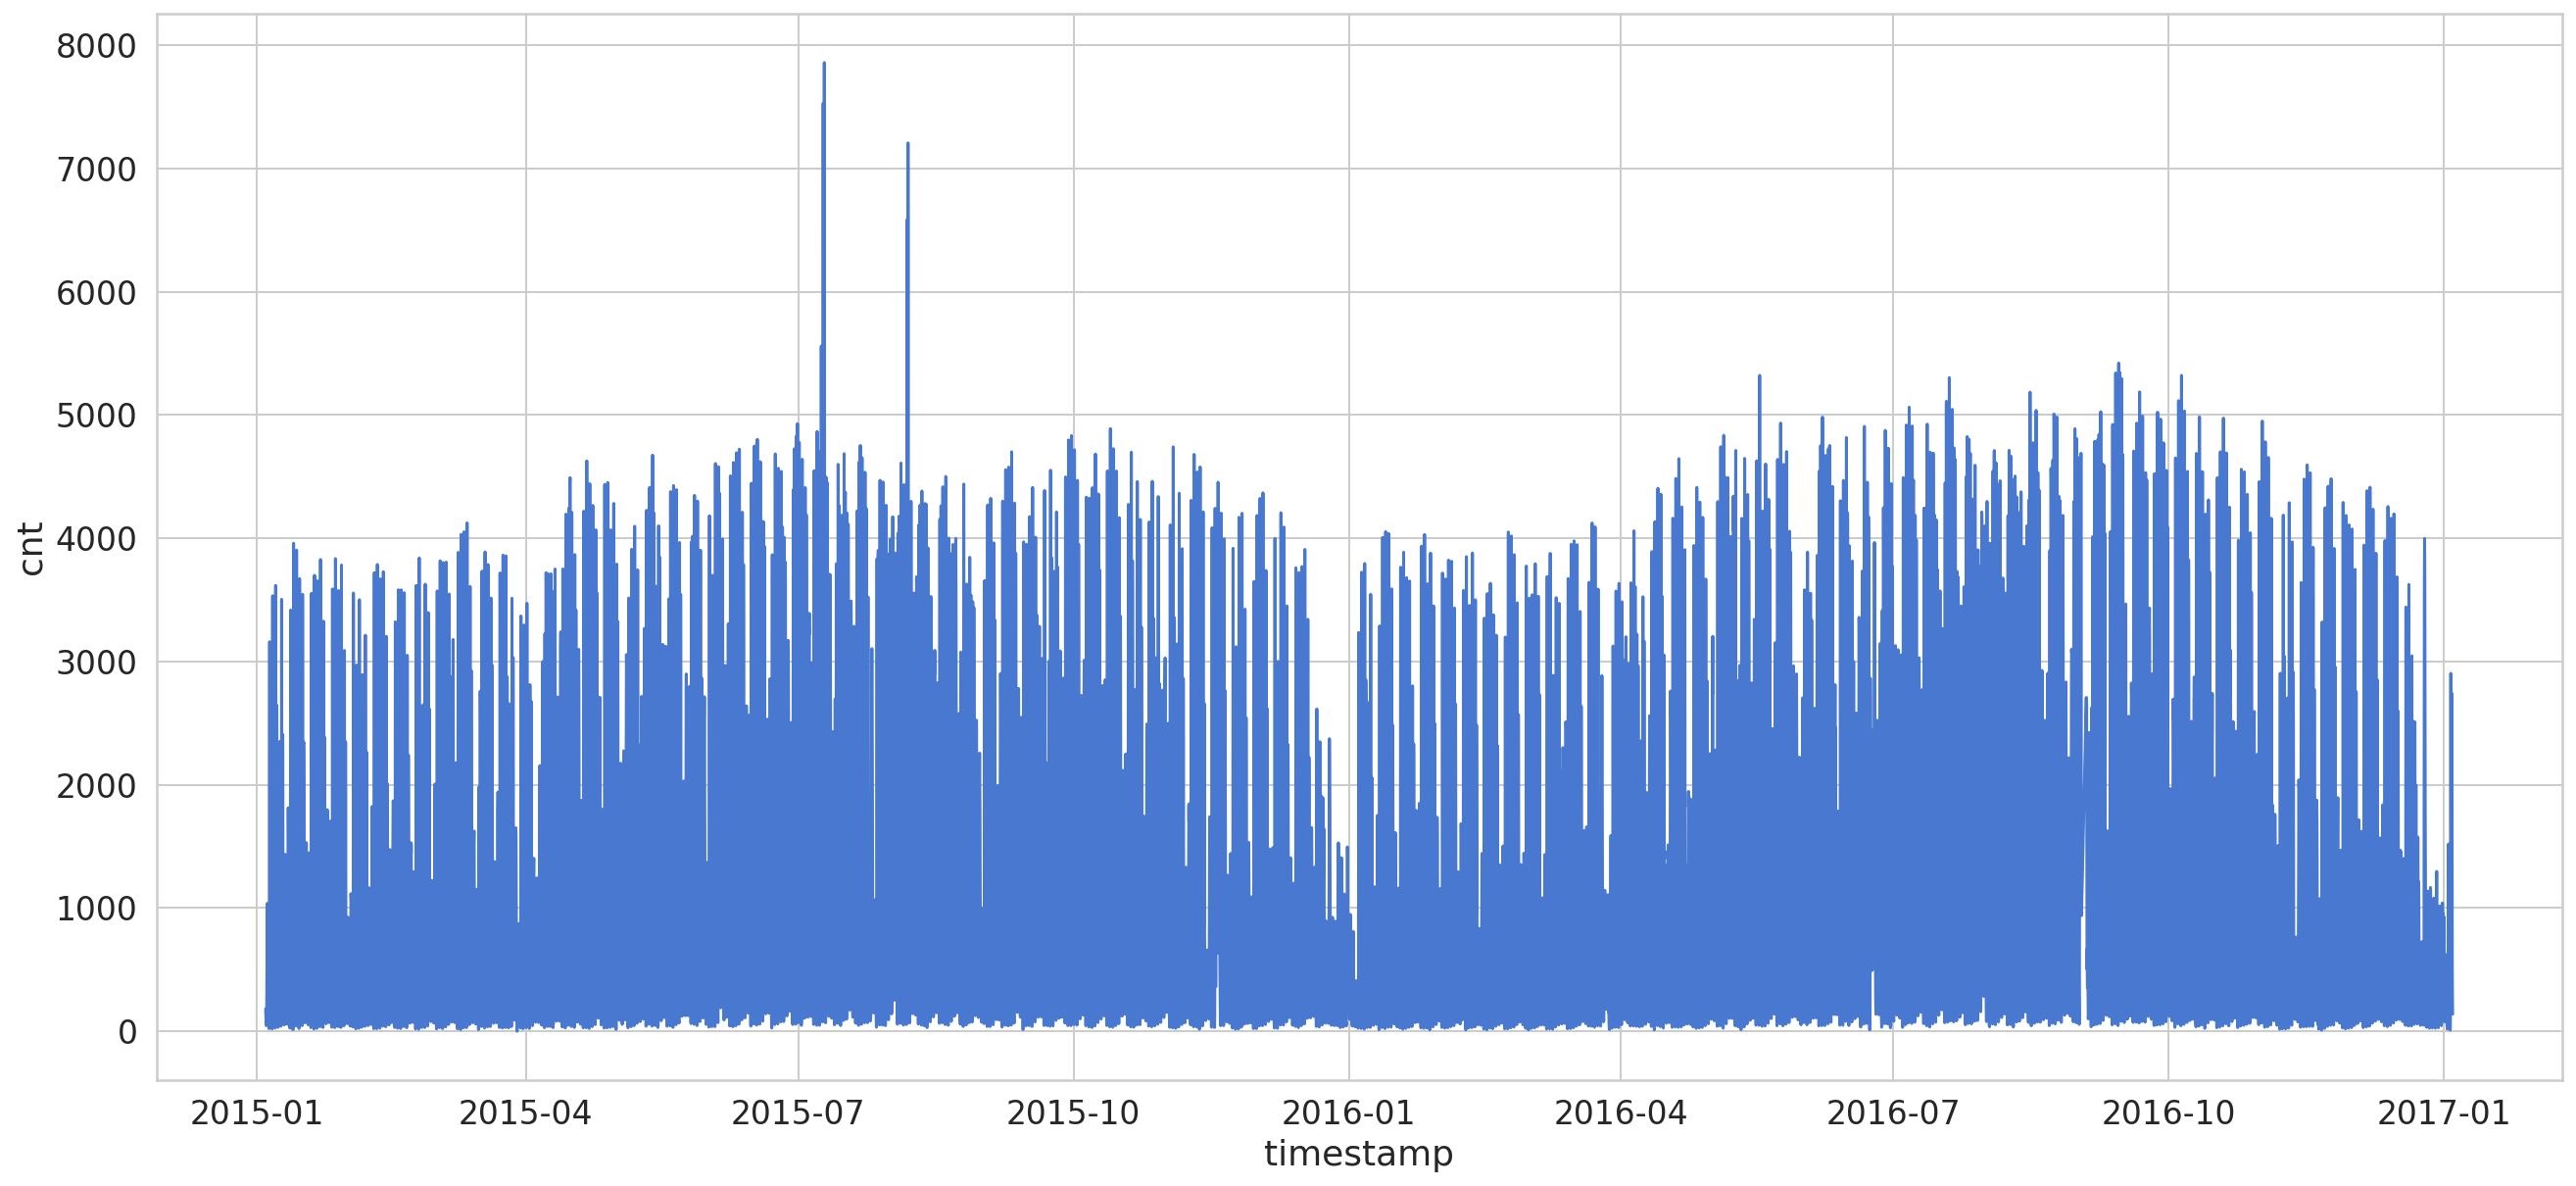

In [0]:
sns.lineplot(x=df.index, y="cnt", data=df);

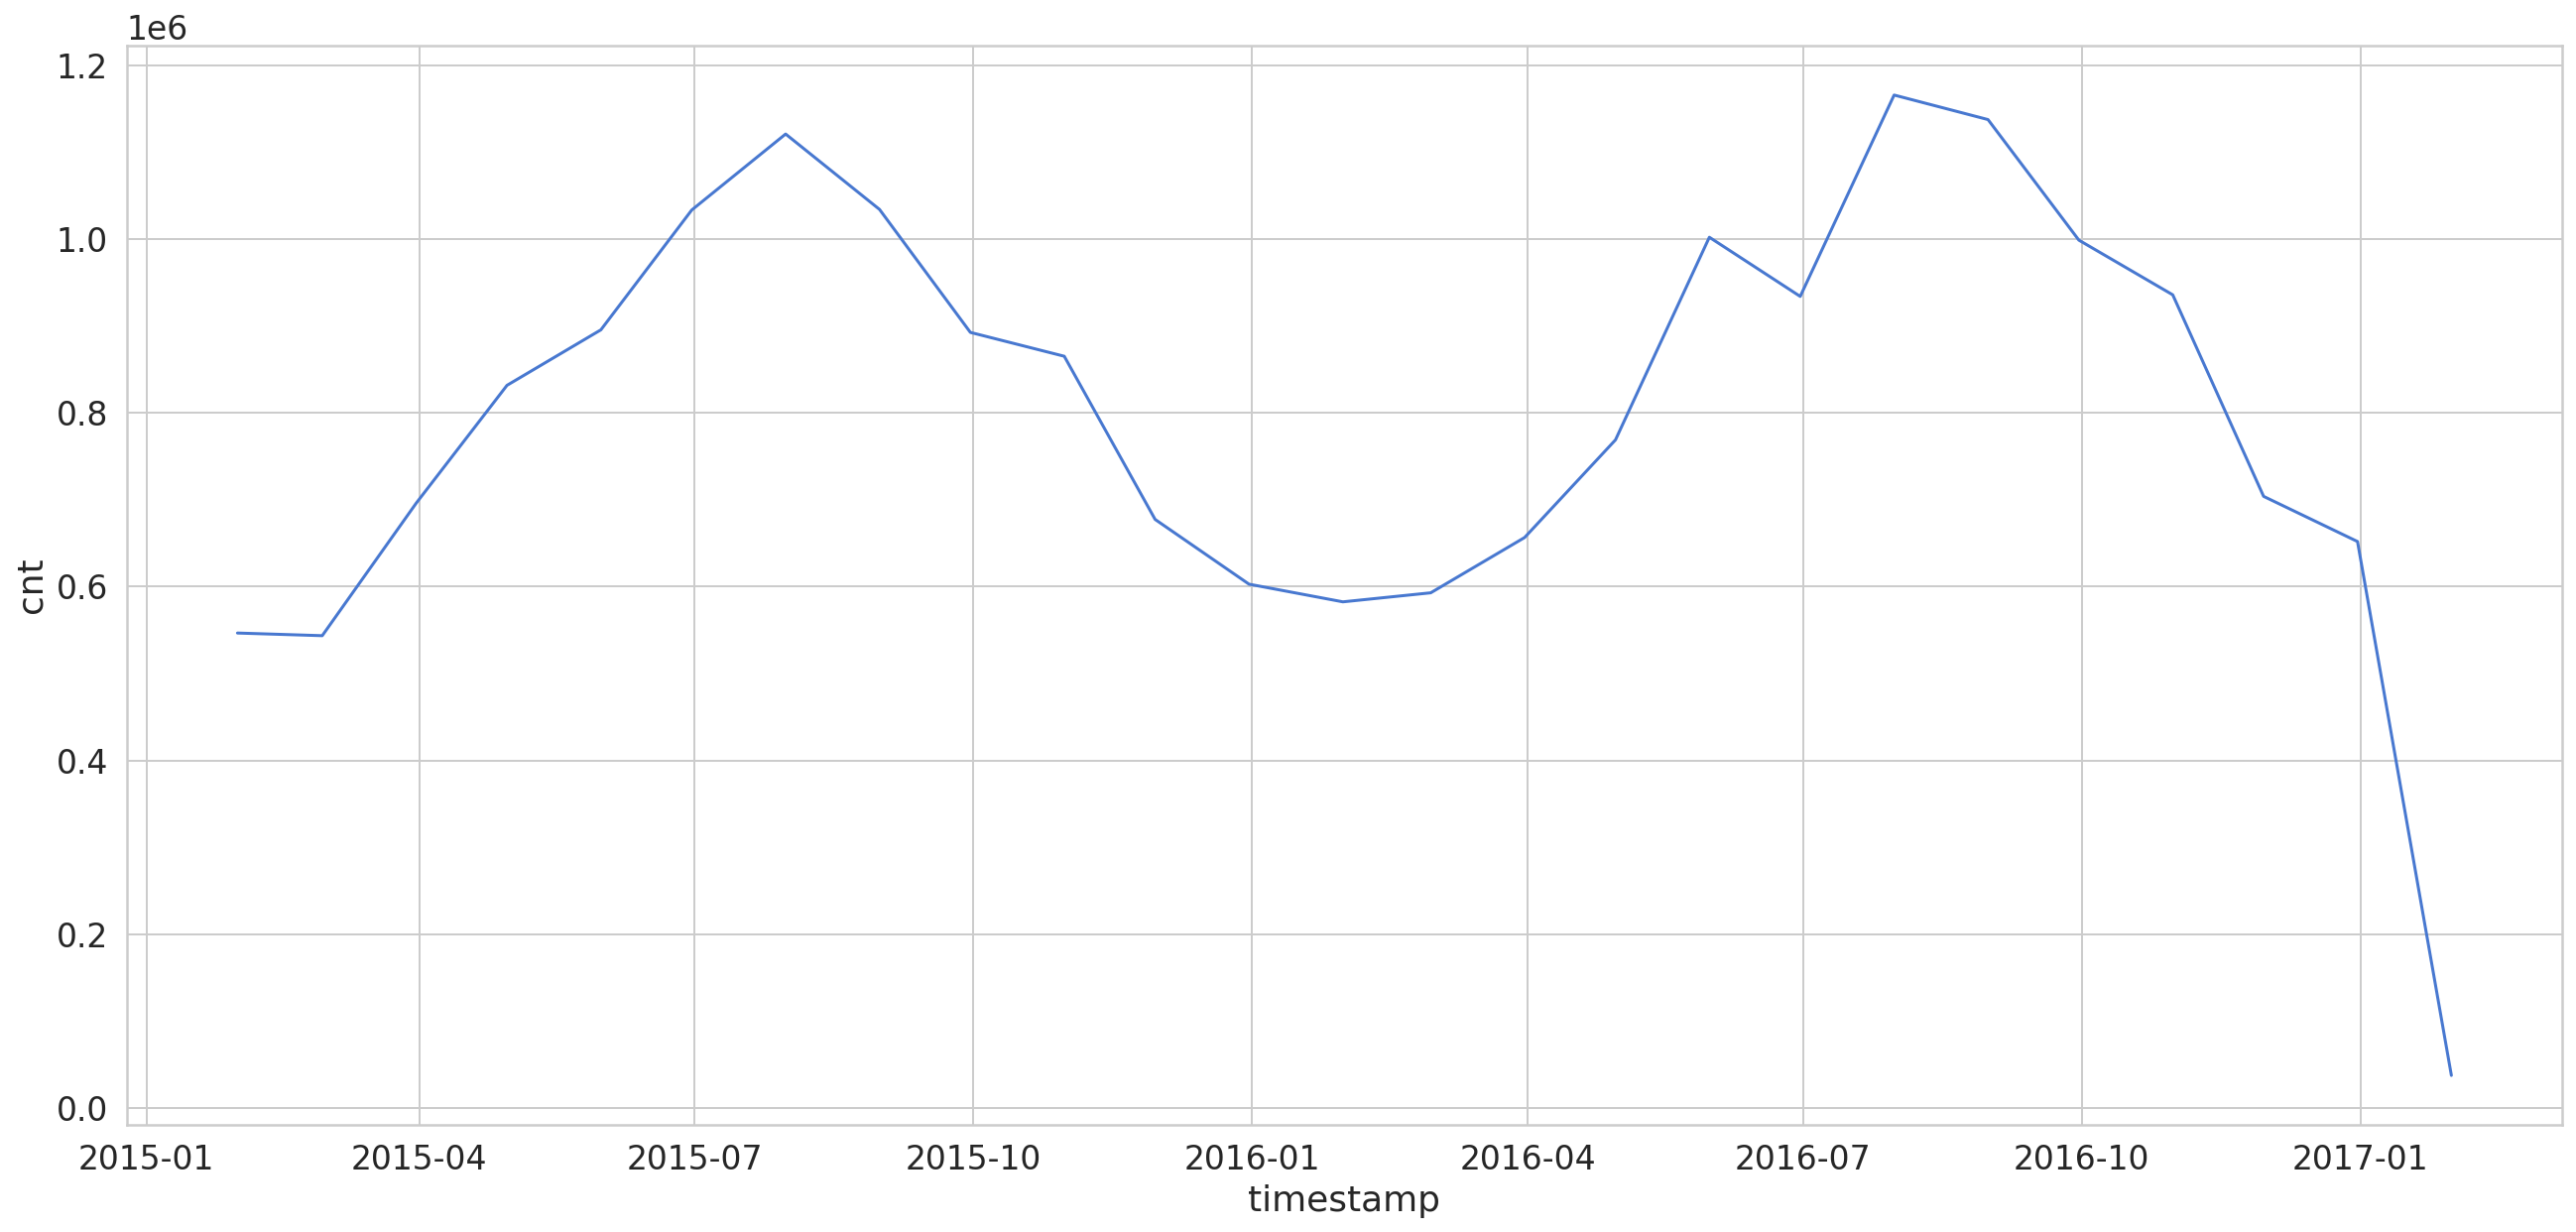

In [0]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

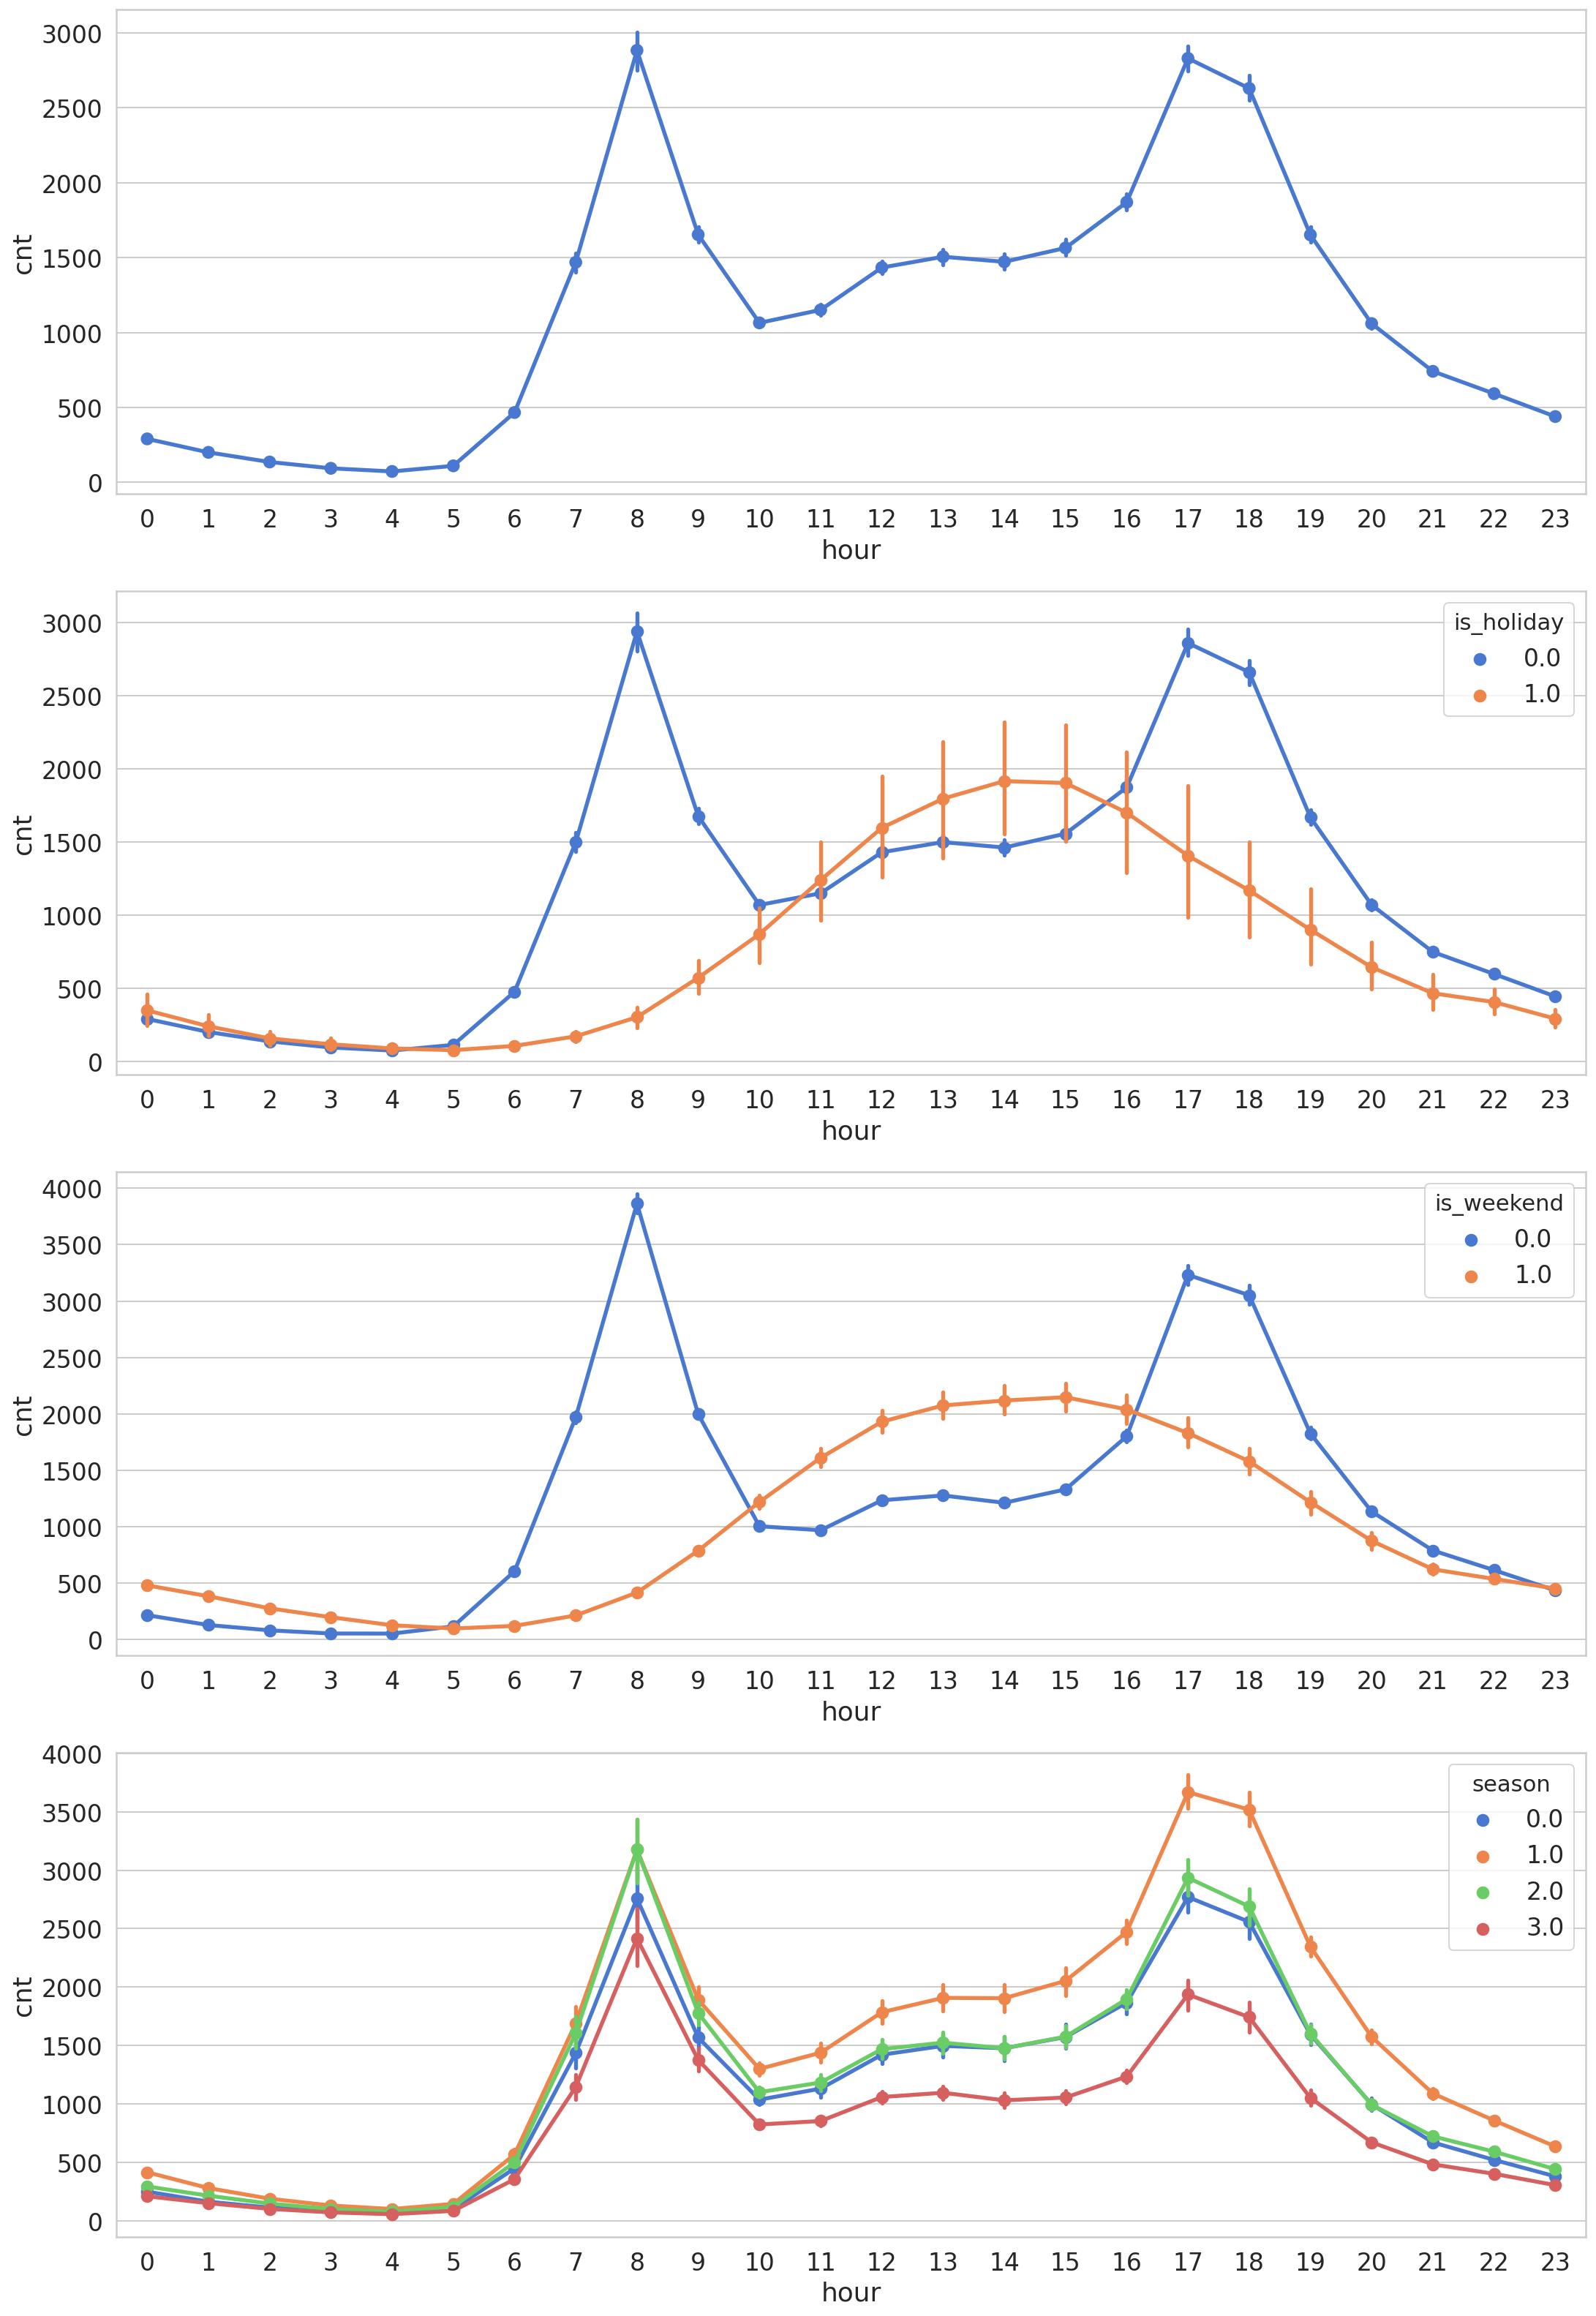

In [0]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

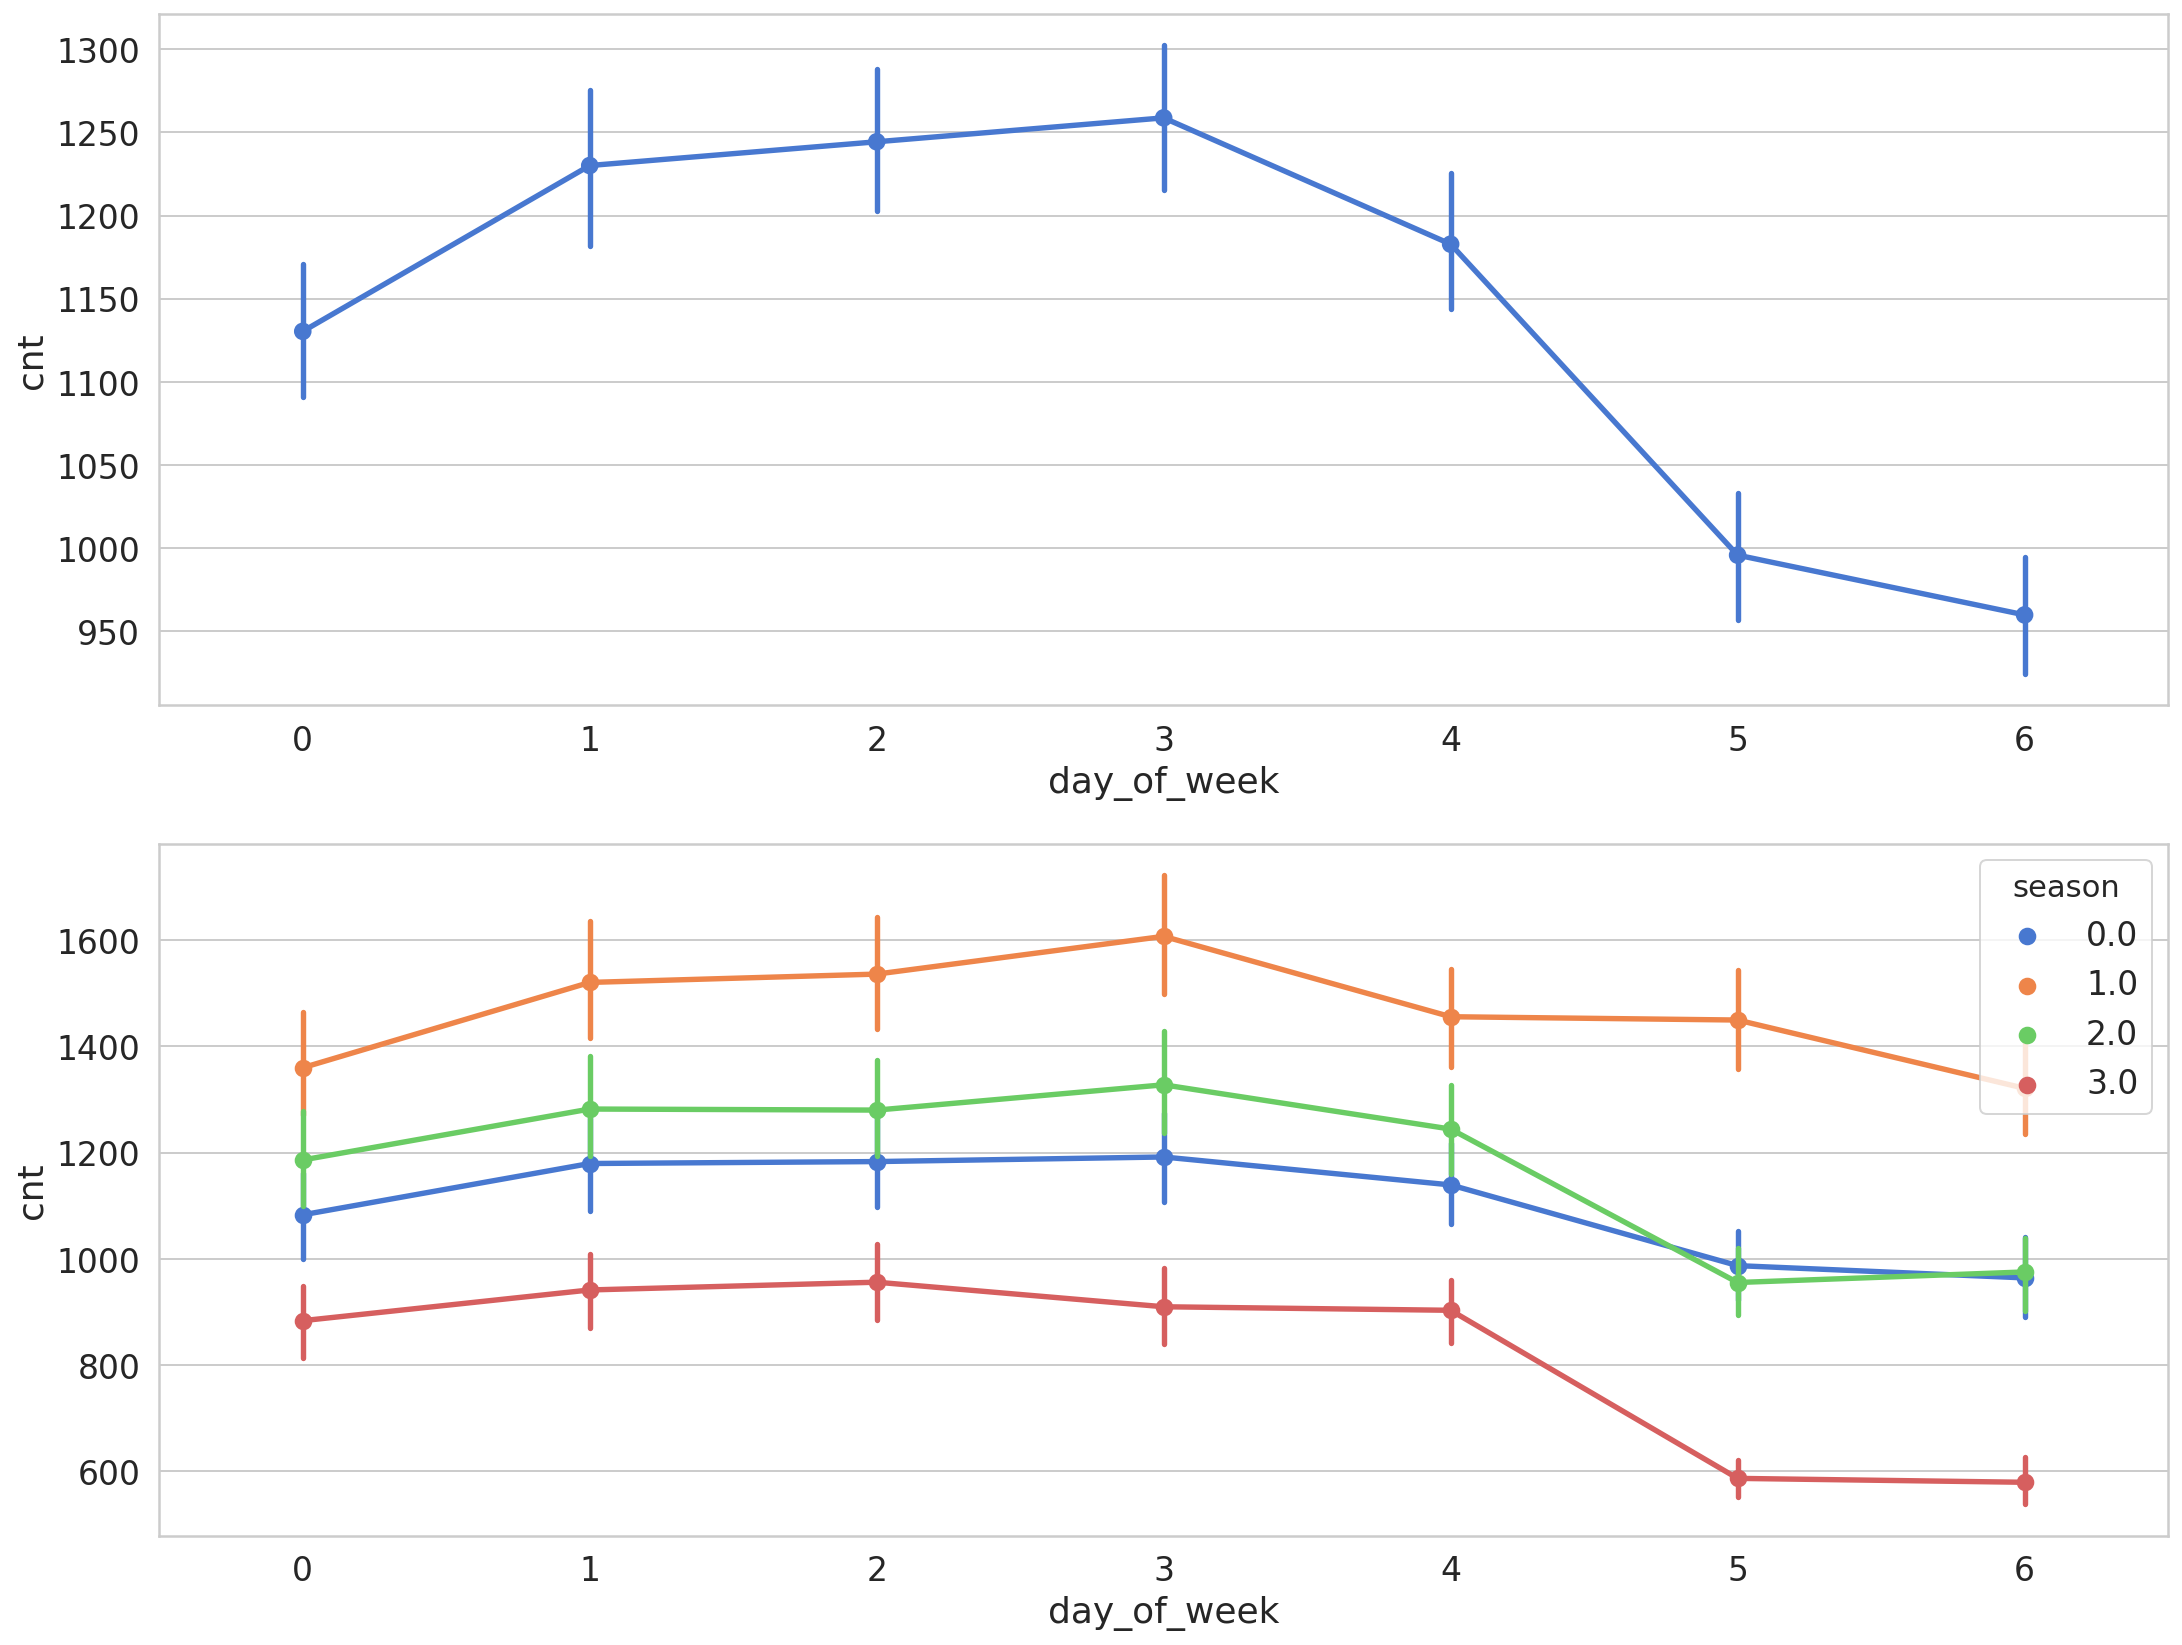

In [0]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

In [0]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


# Preprocessing

In [0]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [0]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [0]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


In [0]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [0]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 14095 samples, validate on 1567 samples
Epoch 1/30
14095/14095 [==============================] - 12s 883us/sample - loss: 0.3126 - val_loss: 0.1138
Epoch 2/30
14095/14095 [==============================] - 4s 313us/sample - loss: 0.0832 - val_loss: 0.0526
Epoch 3/30
14095/14095 [==============================] - 4s 315us/sample - loss: 0.0506 - val_loss: 0.0494
Epoch 4/30
14095/14095 [==============================] - 4s 305us/sample - loss: 0.0384 - val_loss: 0.0389
Epoch 5/30
14095/14095 [==============================] - 4s 304us/sample - loss: 0.0318 - val_loss: 0.0319
Epoch 6/30
14095/14095 [==============================] - 4s 307us/sample - loss: 0.0290 - val_loss: 0.0322
Epoch 7/30
14095/14095 [==============================] - 4s 306us/sample - loss: 0.0260 - val_loss: 0.0368
Epoch 8/30
14095/14095 [==============================] - 4s 304us/sample - loss: 0.0239 - val_loss: 0.0373
Epoch 9/30
14095/14095 [==============================] - 4s 306us/sample - loss: 0.02

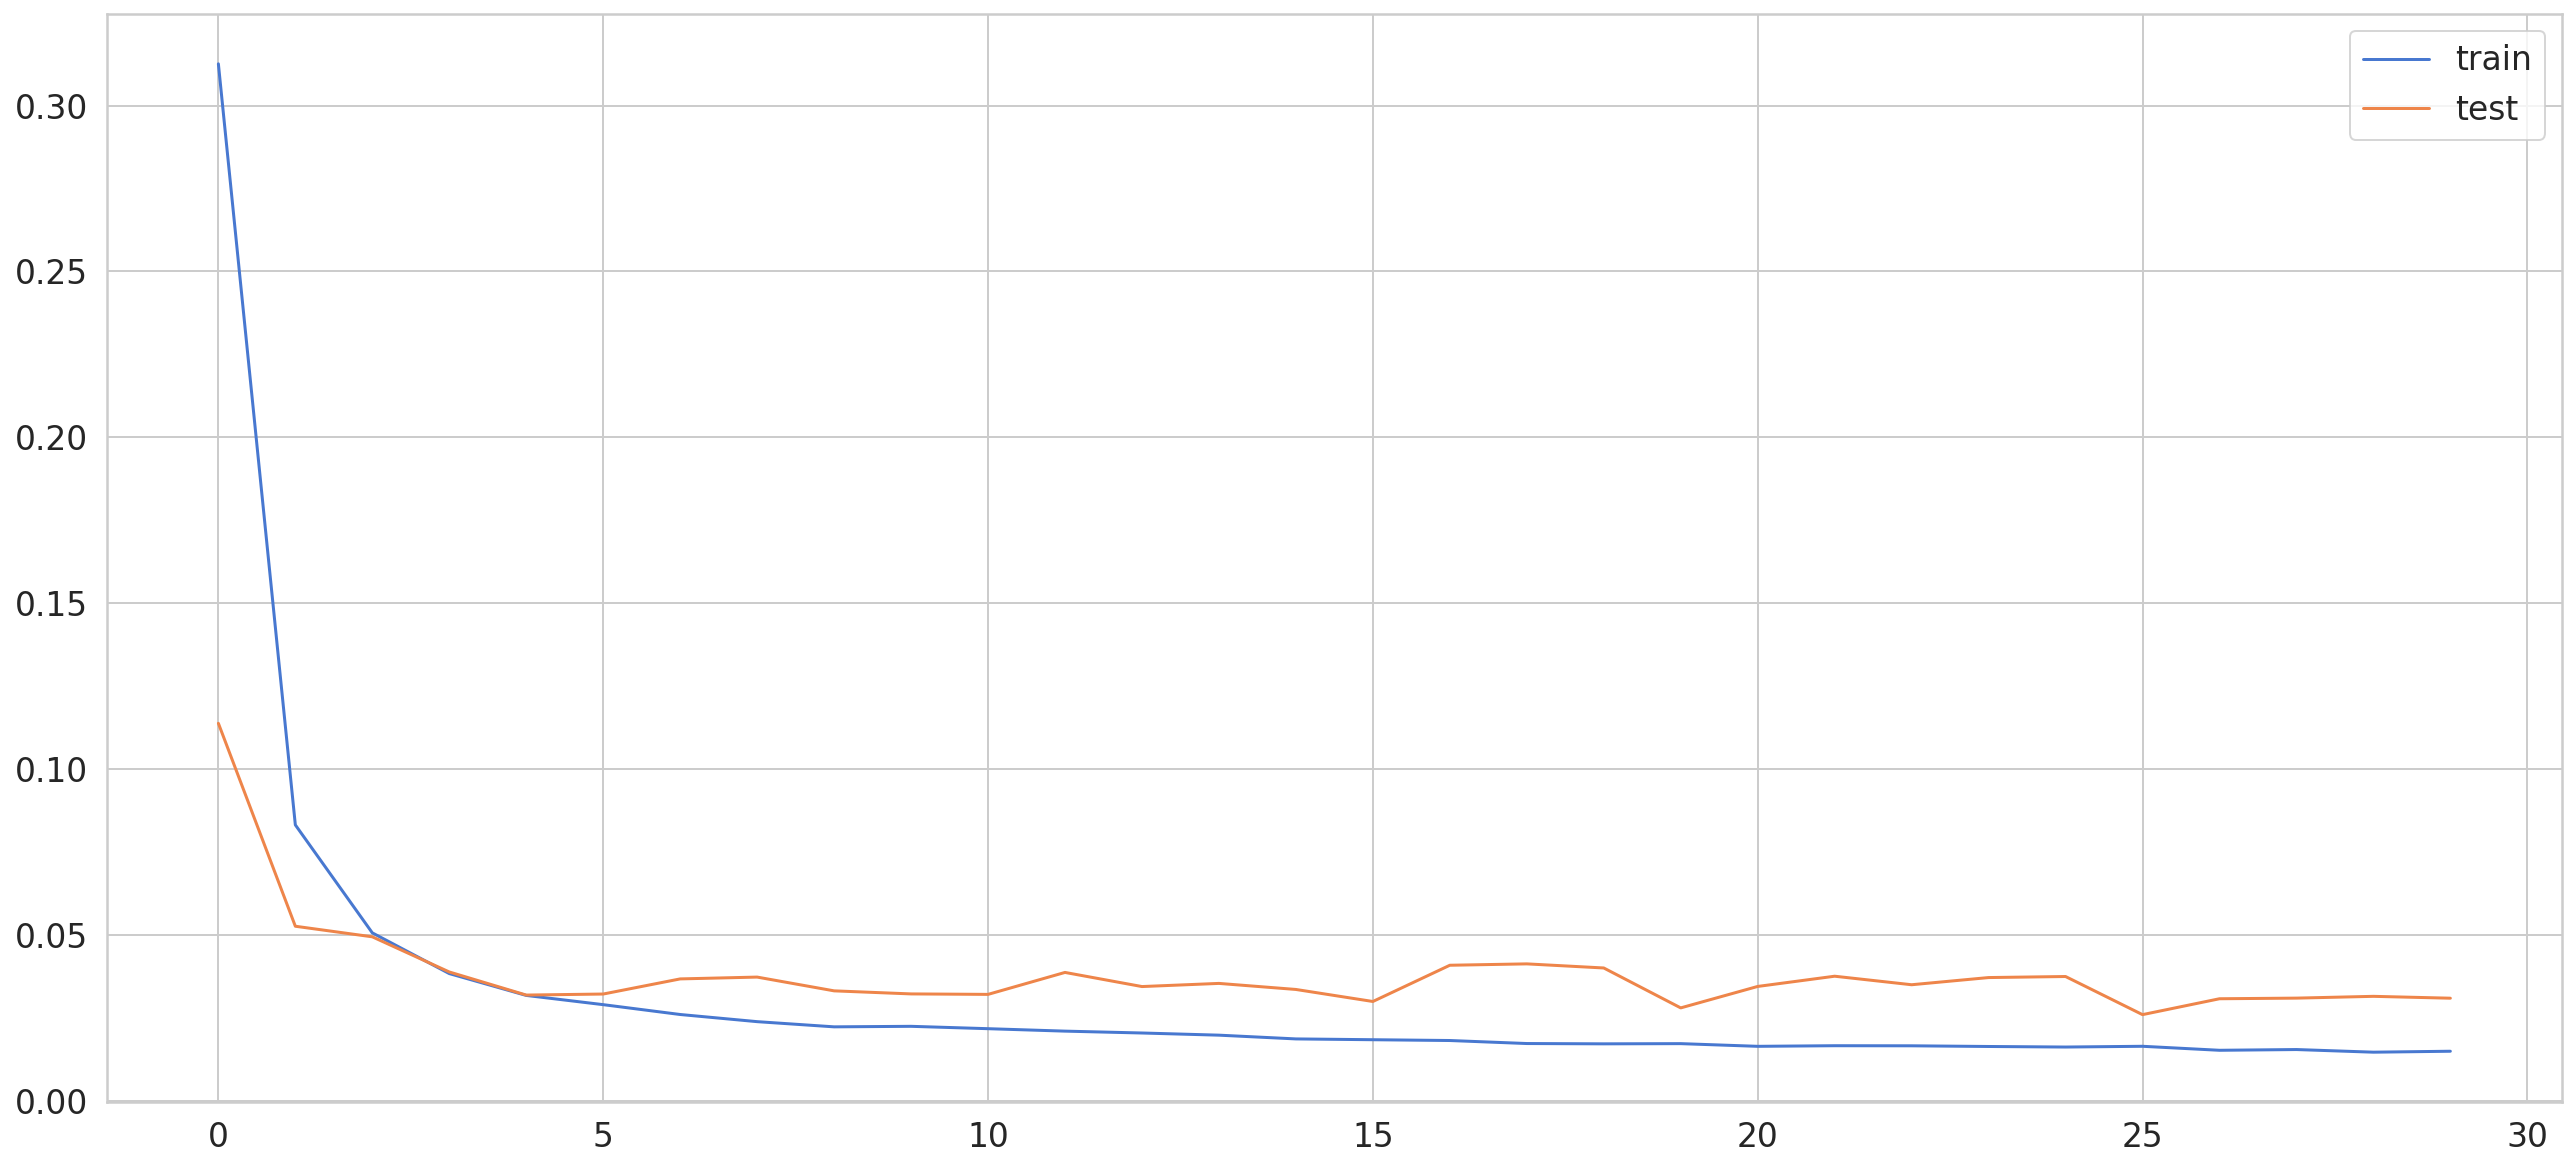

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

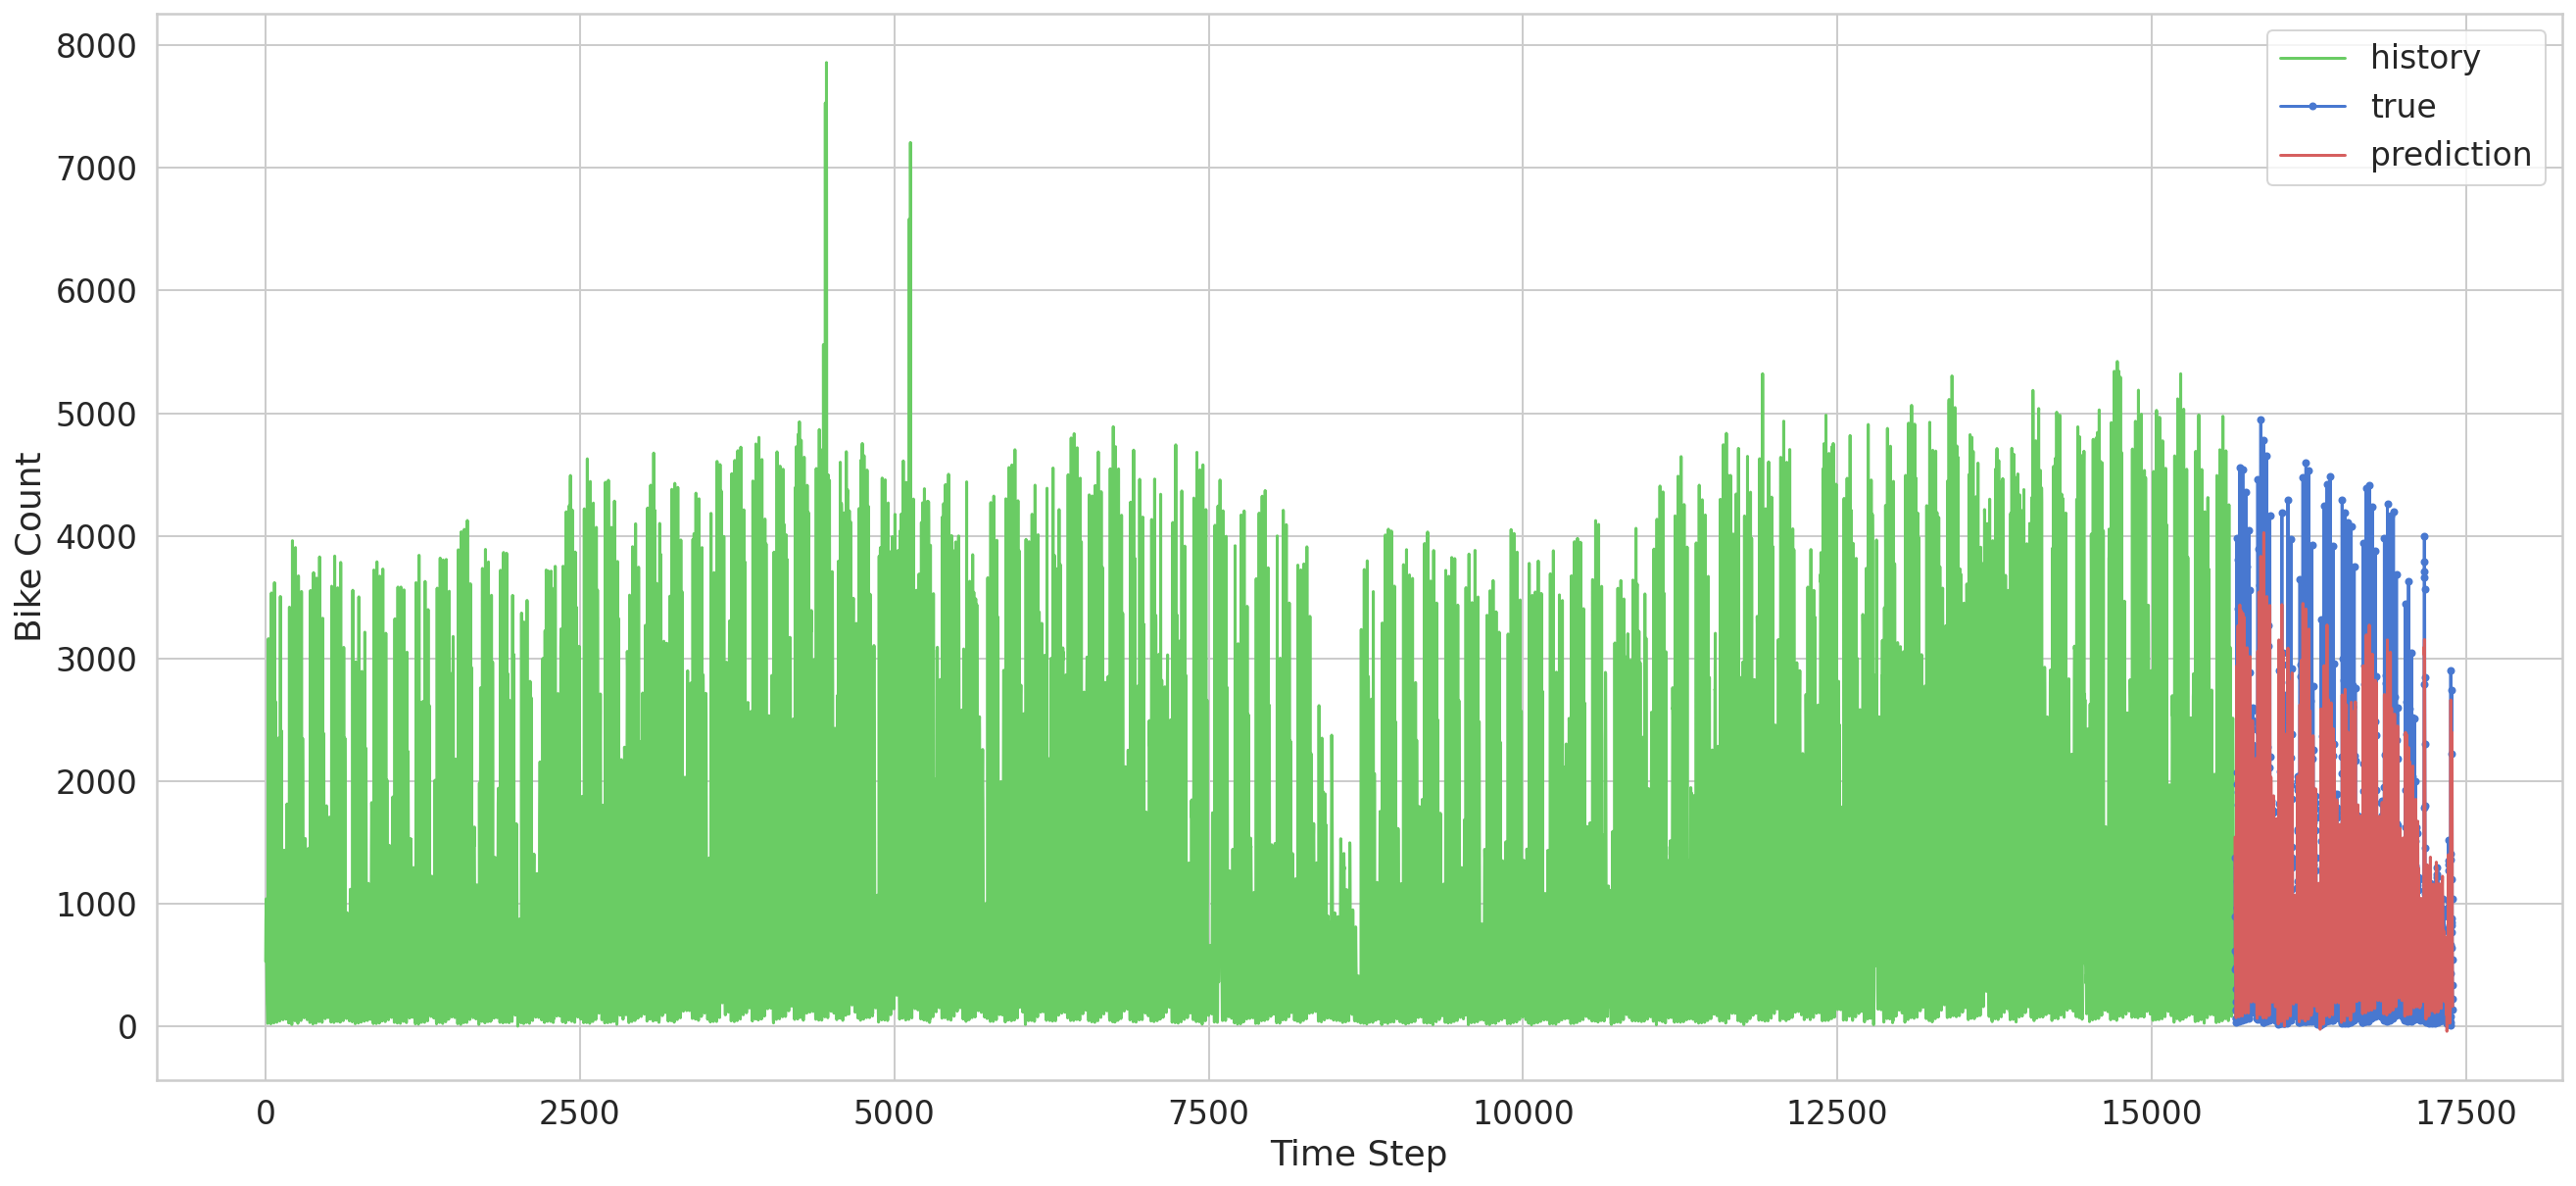

In [0]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

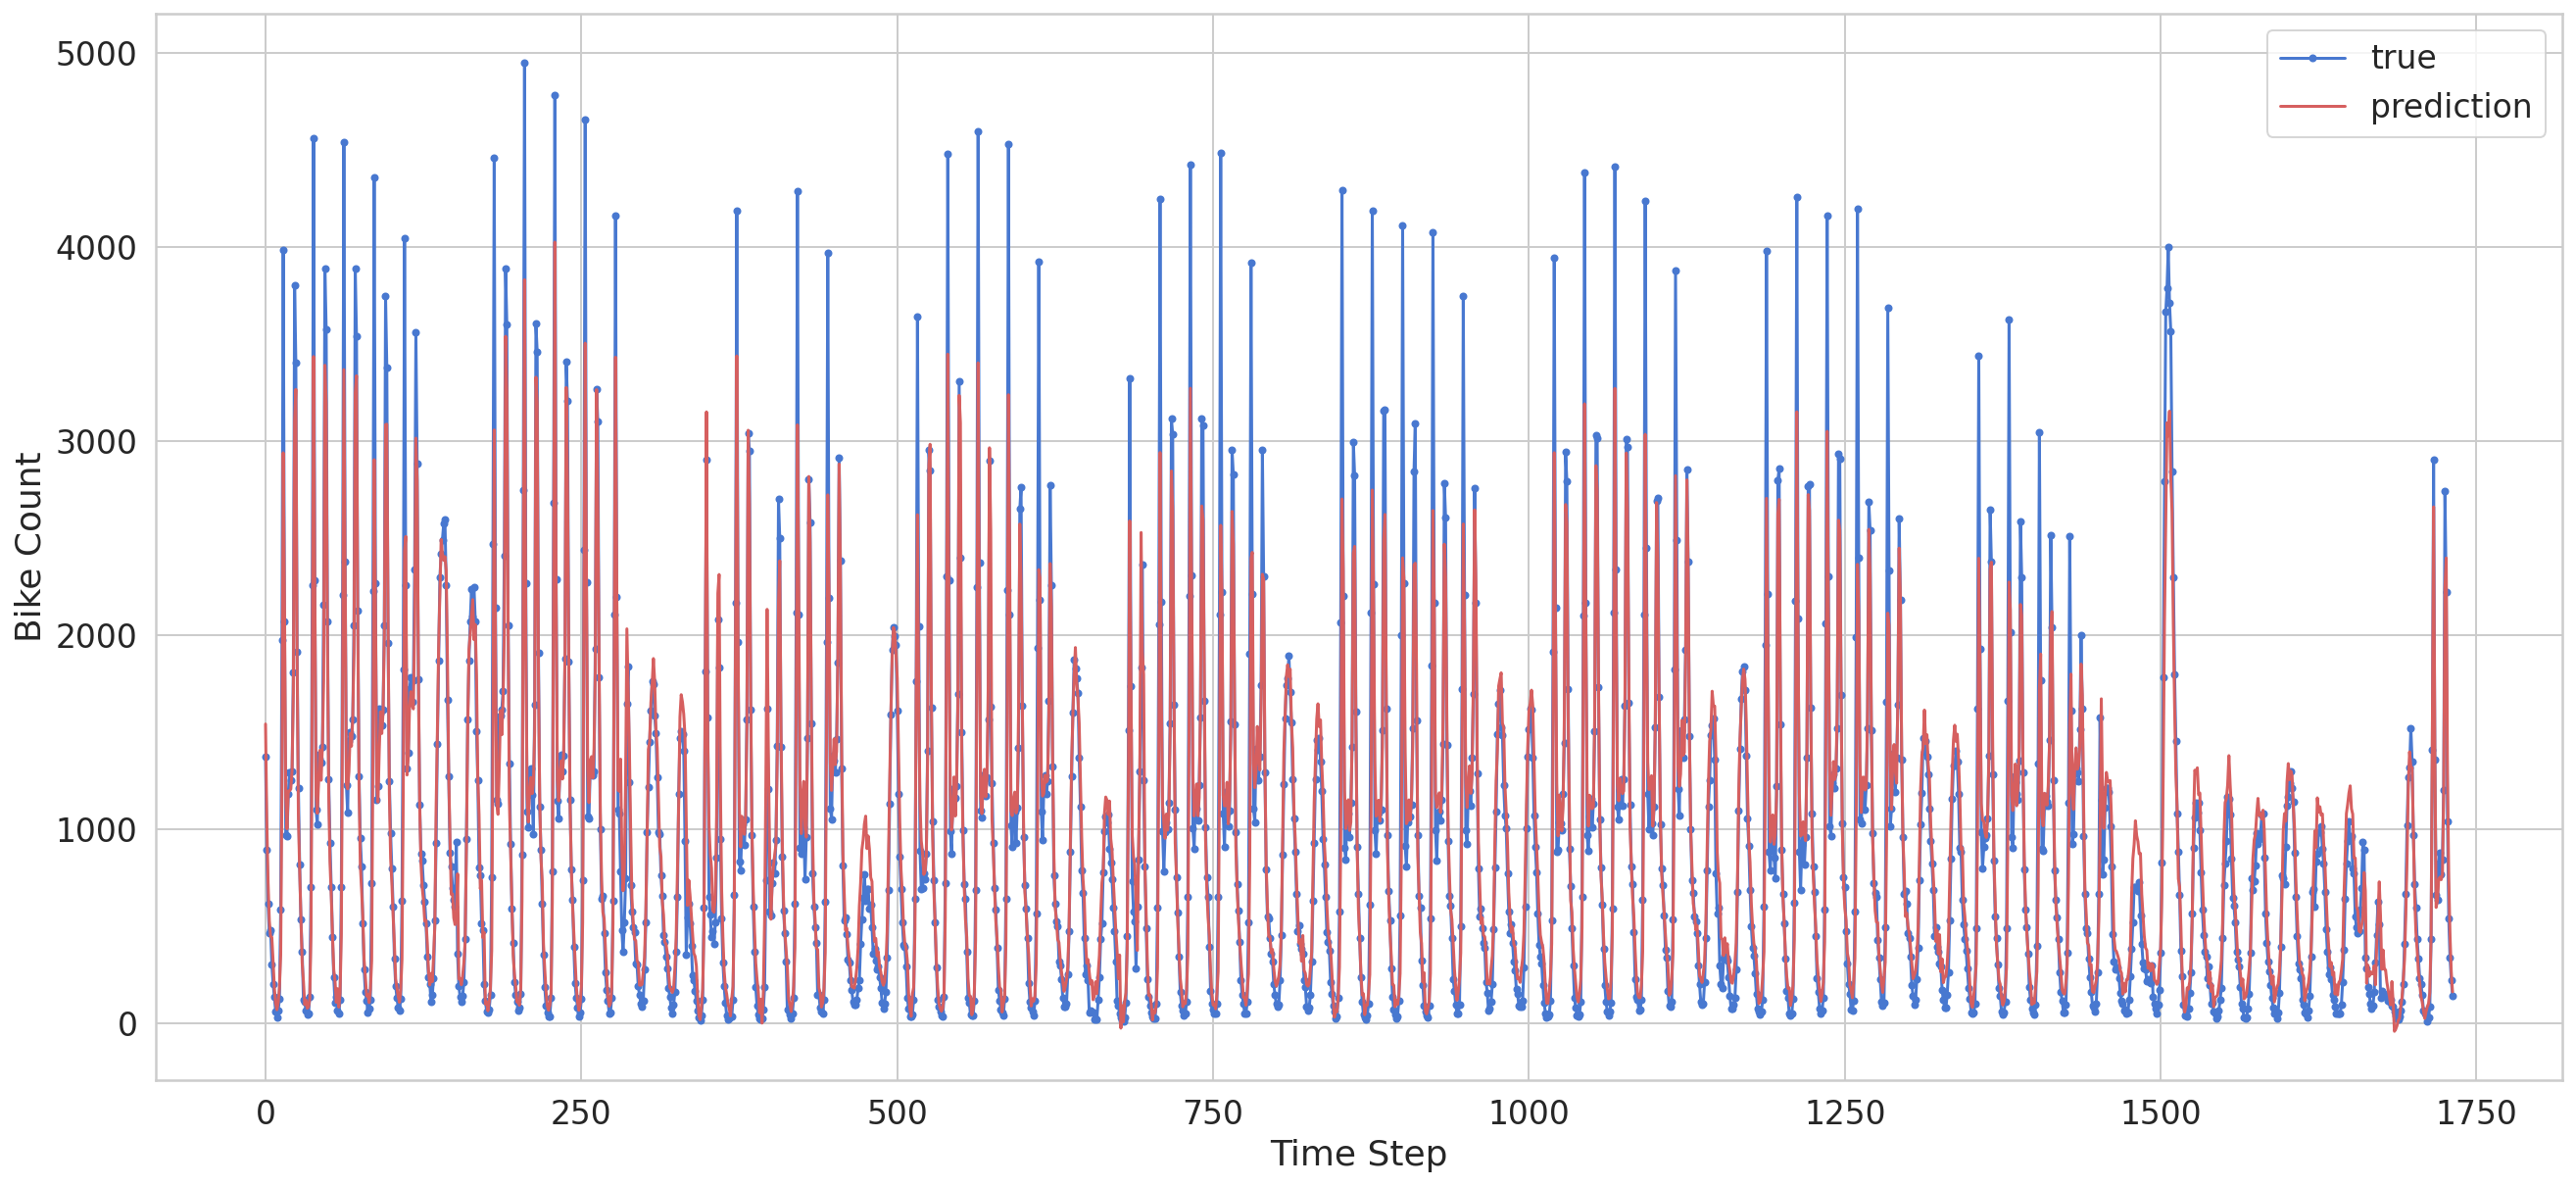

In [0]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();